# TechCabal Ewe Audio Challenge solution code ID:iJ2Gk2F4

# 1. Importing Libraries

In [1]:
# ----------------------------------- Importing libraries--------------------------------------------
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import librosa
from tensorflow.keras.layers import Add, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout, Input, GlobalAveragePooling2D
from sklearn.preprocessing import LabelEncoder
import random
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

## 2. Data Loading and Exploration

              id     audio_filepath  duration class
0  id_6nazjwygdl  id_6nazjwygdl.wav     1.984  left
1  id_jpwl97yilf  id_jpwl97yilf.wav     2.027  down
2  id_9d131fb32p  id_9d131fb32p.wav     2.274    go
3  id_kat2oty4s0  id_kat2oty4s0.wav     2.176  down
4  id_g3hvae3jbe  id_g3hvae3jbe.wav     1.634  down
              id     audio_filepath  duration
0  id_u5iqtgjzhx  id_u5iqtgjzhx.wav   2.35800
1  id_l7ebzcfk5e  id_l7ebzcfk5e.wav   3.22100
2  id_jbzci8uepl  id_jbzci8uepl.wav   2.94898
3  id_jzil0fw5vs  id_jzil0fw5vs.wav   4.33100
4  id_o7mrvf5wj7  id_o7mrvf5wj7.wav   1.85600
Class distribution in the Train Dataset:
class
go       759
down     665
stop     655
left     651
right    651
up       651
yes      651
no       651
Name: count, dtype: int64


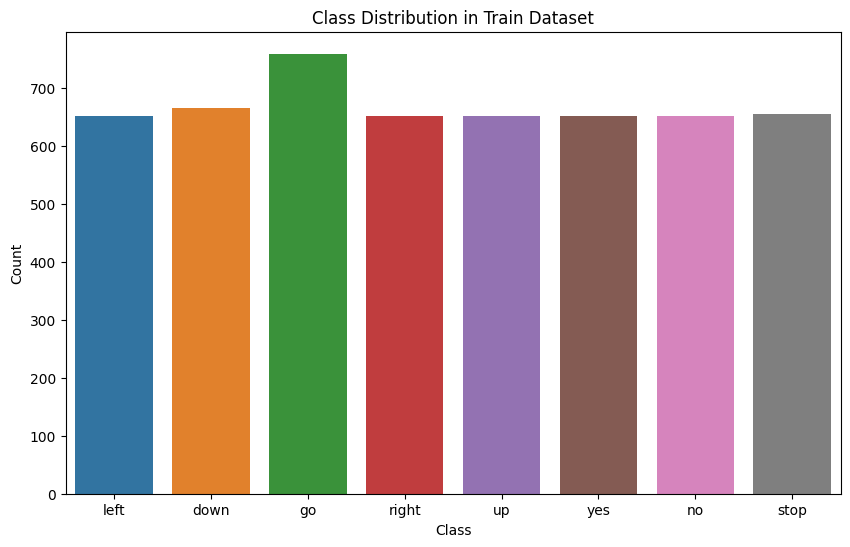

Total number of missing values in the train dataset:
0
Total number of missing values in the test dataset:
0


In [2]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# ----------------------------------------
# Paths and Data Loading
# ----------------------------------------
# Define paths (Update as per Zindi's folder structure with the datasets provided for the competition)

train_csv_path = 'path/to/Train.csv'   # Please update 'train_csv_path' with the correct path to Train.csv
test_csv_path = 'path/to/Test_1.csv'   # Please update 'test_csv_path' with the correct path to Test.csv
audio_dir = 'path/to/audio/files/'     # Please update 'audio_dir' with the correct path to the audio files

# Load CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)



# Load CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Check if files are loaded correctly
print(train_df.head())
print(test_df.head())

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Function to plot the class distribution
def plot_class_distribution(labels, title):
    counter = Counter(labels)
    class_names = list(counter.keys())
    class_counts = list(counter.values())

    # Convert class_names to a pandas Series
    class_names_series = pd.Series(class_names)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_names_series, y=class_counts)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

# Function to get the class distribution in the dataset
def get_class_distribution(df, label_col='class'):
    # Count the number of occurrences of each class in the dataset
    class_counts = df[label_col].value_counts()
    return class_counts

# Get class distribution for train dataset
train_class_distribution = get_class_distribution(train_df, label_col='class')
print("Class distribution in the Train Dataset:")
print(train_class_distribution)

# Plot class distribution for train dataset
plot_class_distribution(train_df['class'], 'Class Distribution in Train Dataset')


missing_values_train = train_df.isnull().sum().sum()
print("Total number of missing values in the train dataset:")
print(missing_values_train)

missing_values_test = test_df.isnull().sum().sum()
print("Total number of missing values in the test dataset:")
print(missing_values_test)




# 2. Data Processing and Feature Engineering

In [3]:
# ----------------------------------------
# Feature Extraction
# ----------------------------------------
# Function to load audio files
def load_audio(file_path, sr=16000):
    try:
        signal, _ = librosa.load(file_path, sr=sr)
        return signal
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return None

# Function to compute advanced features (Mel Spectrogram, MFCC, etc.)
def compute_advanced_features(signal, sr=16000, n_mfcc=40, n_mels=128, max_len=500):
    # Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # MFCC features and its deltas
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    
    # Concatenate all features
    combined = np.concatenate((mel_spec_db, mfcc, mfcc_delta, mfcc_delta2), axis=0)

    # Pad or truncate to max_len
    if combined.shape[1] < max_len:
        pad_width = max_len - combined.shape[1]
        combined = np.pad(combined, ((0, 0), (0, pad_width)), mode='constant')
    else:
        combined = combined[:, :max_len]

    return combined

# ----------------------------------------
# Preprocess and Feature Extraction for Dataset
# ----------------------------------------
def preprocess_data(df, audio_dir, is_train=True, max_len=500):
    X, y = [], []
    label_encoder = LabelEncoder() if is_train else None

    for idx, row in df.iterrows():
        file_id = row['id']
        file_path = os.path.join(audio_dir, f"{file_id}.wav")
        signal = load_audio(file_path)
        if signal is None:
            continue
        
        # Extract features
        features = compute_advanced_features(signal, max_len=max_len)
        X.append(features)

        if is_train:
            y.append(row['class'])

    X = np.array(X)[..., np.newaxis]  # Add channel dimension

    if is_train:
        y = label_encoder.fit_transform(y)
        return X, y, label_encoder
    else:
        return X

# ----------------------------------------
# Precompute Test Data Features (for fast inference)
# ----------------------------------------
def precompute_test_features():
    X_test = preprocess_data(test_df, audio_dir, is_train=False)
    np.save('X_test_precomputed.npy', X_test)


# ----------------------------------------
# Preprocess the Training Data
# ----------------------------------------
X_train, y_train, label_encoder = preprocess_data(train_df, audio_dir, is_train=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=8)
y_val = to_categorical(y_val, num_classes=8)

precompute_test_features()

## 3. Model Building and Training

In [4]:
# ----------------------------------------
# Model Definition (CNN with Residual Blocks)
# ----------------------------------------

input_shape = X_train.shape[1:]  # Shape of input data (Mel Spectrogram dimensions + 1 channel)
num_classes = y_train.shape[1]   # Number of unique class labels
def build_yamnet_improved(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # First Conv Block
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Second Conv Block
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Residual Block (with deeper residual connections)
    residual = Conv2D(256, (1, 1), padding='same')(x)
    residual = BatchNormalization()(residual)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, residual])
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Additional Residual Block
    residual2 = Conv2D(512, (1, 1), padding='same')(x)
    residual2 = BatchNormalization()(residual2)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, residual2])
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Global Average Pooling for better generalization
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.6)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Model initialization and training
simpson = build_yamnet_improved(input_shape, num_classes)
simpson.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=16, callbacks=[reduce_lr , checkpoint])

# Load the best model
best_model = load_model('best_model.keras')
# Evaluate the best model
val_loss, val_acc = best_model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')




Epoch 1/30


I0000 00:00:1727780009.999491     174 service.cc:145] XLA service 0x7ce18c006160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727780009.999545     174 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727780009.999549     174 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1727780048.862674     174 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.3907 - loss: 2.2039
Epoch 1: val_loss improved from inf to 3.36736, saving model to best_model.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 155s 416ms/step - accuracy: 0.3910 - loss: 2.2028 - val_accuracy: 0.1293 - val_loss: 3.3674 - learning_rate: 1.0000e-04
Epoch 2/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.7754 - loss: 1.2353
Epoch 2: val_loss did not improve from 3.36736
267/267 ━━━━━━━━━━━━━━━━━━━━ 78s 294ms/step - accuracy: 0.7757 - loss: 1.2346 - val_accuracy: 0.1190 - val_loss: 5.4484 - learning_rate: 1.0000e-04
Epoch 3/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.9535 - loss: 0.7264
Epoch 3: val_loss improved from 3.36736 to 2.87634, saving model to best_model.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 79s 295ms/step - accuracy: 0.9536 - loss: 0.7262 - val_accuracy: 0.3749 - val_loss: 2.8763 - learning_rate: 1.0000e-04
Epoch 4/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9756 - loss: 0.6047
E

## 4. Inference & Submission

In [7]:
X_test = np.load('X_test_precomputed.npy')

# Make predictions
predictions = best_model.predict(X_test)
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

# Prepare submission
submission = pd.DataFrame({
    'id': test_df['id'],
    'class': predicted_labels
})

# Save submission
submission.to_csv('final_submission.csv', index=False)
print("Submission file created successfully!")

93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step
Submission file created successfully!
